In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [7]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

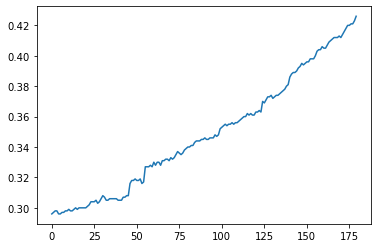

In [8]:
df = df[:180]
df.plot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [10]:
train = df_scaled

In [11]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [13]:
x_train.shape

(128, 20, 1)

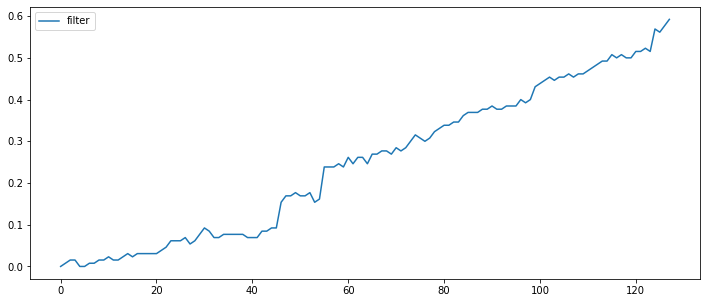

In [14]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

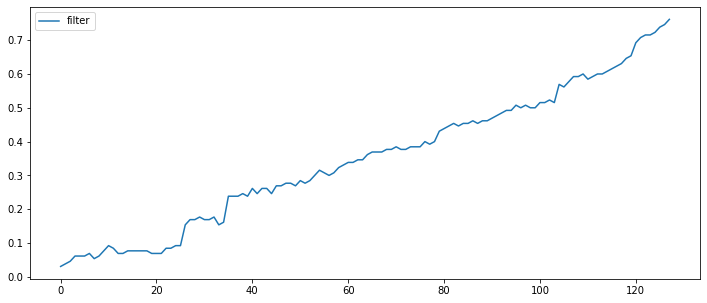

In [15]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [16]:
OUT_STEPS = 20

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [18]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 3ms/step - loss: 0.1250 - mean_absolute_error: 0.2986
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1115 - mean_absolute_error: 0.2749
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0958 - mean_absolute_error: 0.2498
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0759 - mean_absolute_error: 0.2139
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0716 - mean_absolute_error: 0.2047
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0440 - mean_absolute_error: 0.1503
Epoch 7/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0260 - mean_absolute_error: 0.1194
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0168 - mean_absolute_error: 0.0969
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_error: 0.0680
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 3ms/step - loss: 3.1204e-04 - mean_absolute_error: 0.0132
Epoch 74/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.0322e-04 - mean_absolute_error: 0.0132
Epoch 75/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.5398e-04 - mean_absolute_error: 0.0120
Epoch 76/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.9080e-04 - mean_absolute_error: 0.0127
Epoch 77/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8763e-04 - mean_absolute_error: 0.0125
Epoch 78/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0122
Epoch 79/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.5277e-04 - mean_absolute_error: 0.0120
Epoch 80/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8897e-04 - mean_absolute_error: 0.0129
Epoch 81/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.9369e-04 - mean_absolute_er

8/8 [==============================] - 0s 3ms/step - loss: 2.3909e-04 - mean_absolute_error: 0.0118
Epoch 145/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3459e-04 - mean_absolute_error: 0.0117
Epoch 146/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2827e-04 - mean_absolute_error: 0.0117
Epoch 147/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3955e-04 - mean_absolute_error: 0.0118
Epoch 148/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4085e-04 - mean_absolute_error: 0.0119
Epoch 149/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3627e-04 - mean_absolute_error: 0.0117
Epoch 150/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4987e-04 - mean_absolute_error: 0.0121
Epoch 151/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2544e-04 - mean_absolute_error: 0.0114
Epoch 152/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4167e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.0541e-04 - mean_absolute_error: 0.0111
Epoch 214/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9800e-04 - mean_absolute_error: 0.0109
Epoch 215/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1033e-04 - mean_absolute_error: 0.0113
Epoch 216/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0642e-04 - mean_absolute_error: 0.0111
Epoch 217/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0854e-04 - mean_absolute_error: 0.0112
Epoch 218/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2802e-04 - mean_absolute_error: 0.0119
Epoch 219/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2651e-04 - mean_absolute_error: 0.0118
Epoch 220/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3791e-04 - mean_absolute_error: 0.0121
Epoch 221/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3206e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.0048e-04 - mean_absolute_error: 0.0110
Epoch 285/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8218e-04 - mean_absolute_error: 0.0106
Epoch 286/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9588e-04 - mean_absolute_error: 0.0109
Epoch 287/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1404e-04 - mean_absolute_error: 0.0116
Epoch 288/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9684e-04 - mean_absolute_error: 0.0109
Epoch 289/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0161e-04 - mean_absolute_error: 0.0110
Epoch 290/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0153e-04 - mean_absolute_error: 0.0111
Epoch 291/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0689e-04 - mean_absolute_error: 0.0114
Epoch 292/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0416e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.9204e-04 - mean_absolute_error: 0.0106
Epoch 355/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7803e-04 - mean_absolute_error: 0.0104
Epoch 356/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9241e-04 - mean_absolute_error: 0.0108
Epoch 357/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8451e-04 - mean_absolute_error: 0.0106
Epoch 358/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9497e-04 - mean_absolute_error: 0.0109
Epoch 359/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9308e-04 - mean_absolute_error: 0.0108
Epoch 360/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9176e-04 - mean_absolute_error: 0.0108
Epoch 361/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7938e-04 - mean_absolute_error: 0.0104
Epoch 362/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8467e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.9137e-04 - mean_absolute_error: 0.0105
Epoch 425/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8154e-04 - mean_absolute_error: 0.0104
Epoch 426/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8337e-04 - mean_absolute_error: 0.0104
Epoch 427/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7782e-04 - mean_absolute_error: 0.0103
Epoch 428/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6489e-04 - mean_absolute_error: 0.0099
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8445e-04 - mean_absolute_error: 0.0105
Epoch 430/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8499e-04 - mean_absolute_error: 0.0106
Epoch 431/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7687e-04 - mean_absolute_error: 0.0103
Epoch 432/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9480e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7811e-04 - mean_absolute_error: 0.0103
Epoch 496/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6061e-04 - mean_absolute_error: 0.0097
Epoch 497/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6755e-04 - mean_absolute_error: 0.0099
Epoch 498/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6870e-04 - mean_absolute_error: 0.0099
Epoch 499/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6897e-04 - mean_absolute_error: 0.0099
Epoch 500/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7209e-04 - mean_absolute_error: 0.0099
Epoch 501/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6945e-04 - mean_absolute_error: 0.0100
Epoch 502/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7045e-04 - mean_absolute_error: 0.0100
Epoch 503/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6174e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.6989e-04 - mean_absolute_error: 0.0100
Epoch 567/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6924e-04 - mean_absolute_error: 0.0099
Epoch 568/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8776e-04 - mean_absolute_error: 0.0105
Epoch 569/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5777e-04 - mean_absolute_error: 0.0097
Epoch 570/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9302e-04 - mean_absolute_error: 0.0106
Epoch 571/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5421e-04 - mean_absolute_error: 0.0095
Epoch 572/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7696e-04 - mean_absolute_error: 0.0101
Epoch 573/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6762e-04 - mean_absolute_error: 0.0098
Epoch 574/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7097e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4910e-04 - mean_absolute_error: 0.0093
Epoch 637/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5902e-04 - mean_absolute_error: 0.0095
Epoch 638/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6866e-04 - mean_absolute_error: 0.0097
Epoch 639/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5381e-04 - mean_absolute_error: 0.0094
Epoch 640/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5497e-04 - mean_absolute_error: 0.0094
Epoch 641/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6084e-04 - mean_absolute_error: 0.0097
Epoch 642/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6238e-04 - mean_absolute_error: 0.0097
Epoch 643/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4892e-04 - mean_absolute_error: 0.0093
Epoch 644/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6012e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.6652e-04 - mean_absolute_error: 0.0099
Epoch 708/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4269e-04 - mean_absolute_error: 0.0090
Epoch 709/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2810e-04 - mean_absolute_error: 0.0086
Epoch 710/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3646e-04 - mean_absolute_error: 0.0089
Epoch 711/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5825e-04 - mean_absolute_error: 0.0095
Epoch 712/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3564e-04 - mean_absolute_error: 0.0088
Epoch 713/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5928e-04 - mean_absolute_error: 0.0095
Epoch 714/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6336e-04 - mean_absolute_error: 0.0097
Epoch 715/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4665e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.2972e-04 - mean_absolute_error: 0.0084
Epoch 779/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4369e-04 - mean_absolute_error: 0.0089
Epoch 780/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2387e-04 - mean_absolute_error: 0.0082
Epoch 781/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.2806e-04 - mean_absolute_error: 0.0084
Epoch 782/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4523e-04 - mean_absolute_error: 0.0089
Epoch 783/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3134e-04 - mean_absolute_error: 0.0085
Epoch 784/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2684e-04 - mean_absolute_error: 0.0083
Epoch 785/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3430e-04 - mean_absolute_error: 0.0086
Epoch 786/1000
8/8 [==============================] - ETA: 0s - loss: 1.3126e-04 - mean_absolut

8/8 [==============================] - 0s 3ms/step - loss: 1.3855e-04 - mean_absolute_error: 0.0087
Epoch 849/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3866e-04 - mean_absolute_error: 0.0086
Epoch 850/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4041e-04 - mean_absolute_error: 0.0086
Epoch 851/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1777e-04 - mean_absolute_error: 0.0079
Epoch 852/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3896e-04 - mean_absolute_error: 0.0086
Epoch 853/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3503e-04 - mean_absolute_error: 0.0084
Epoch 854/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3792e-04 - mean_absolute_error: 0.0086
Epoch 855/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3325e-04 - mean_absolute_error: 0.0085
Epoch 856/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3746e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.3190e-04 - mean_absolute_error: 0.0085
Epoch 919/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1912e-04 - mean_absolute_error: 0.0081
Epoch 920/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3838e-04 - mean_absolute_error: 0.0087
Epoch 921/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3038e-04 - mean_absolute_error: 0.0083
Epoch 922/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.0906e-04 - mean_absolute_error: 0.0077
Epoch 923/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1151e-04 - mean_absolute_error: 0.0077
Epoch 924/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2996e-04 - mean_absolute_error: 0.0082
Epoch 925/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3225e-04 - mean_absolute_error: 0.0083
Epoch 926/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5780e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.2559e-04 - mean_absolute_error: 0.0080
Epoch 990/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1620e-04 - mean_absolute_error: 0.0078
Epoch 991/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1829e-04 - mean_absolute_error: 0.0080
Epoch 992/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2838e-04 - mean_absolute_error: 0.0083
Epoch 993/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2343e-04 - mean_absolute_error: 0.0081
Epoch 994/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2057e-04 - mean_absolute_error: 0.0079
Epoch 995/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.1657e-04 - mean_absolute_error: 0.0079
Epoch 996/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.0745e-04 - mean_absolute_error: 0.0074
Epoch 997/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2751e-04 - mean_abs

num 0 12.737335608555798 actual 0.6190476190476186 prediction 0.6978978
num 1 6.313985586166476 actual 0.6666666666666661 prediction 0.7087599
num 2 2.690818309784045 actual 0.7142857142857135 prediction 0.73350585
num 3 2.769910916686166 actual 0.7619047619047628 prediction 0.7408007
num 4 4.4520485401154675 actual 0.7142857142857135 prediction 0.74608606
num 5 17.279294133186447 actual 0.6666666666666661 prediction 0.78186196
num 6 18.10396611690532 actual 0.6666666666666661 prediction 0.7873598
num 7 25.884240865707508 actual 0.6666666666666661 prediction 0.8392283
num 8 18.838676214218268 actual 0.7142857142857135 prediction 0.8488477
num 9 18.154706954956183 actual 0.7142857142857135 prediction 0.8439622
num 10 23.522878885269296 actual 0.7142857142857135 prediction 0.8823063
num 11 30.54133355617535 actual 0.6666666666666661 prediction 0.87027556
num 12 26.227438449859754 actual 0.7142857142857135 prediction 0.90162456
num 13 14.872617274522653 actual 0.7619047619047628 predictio

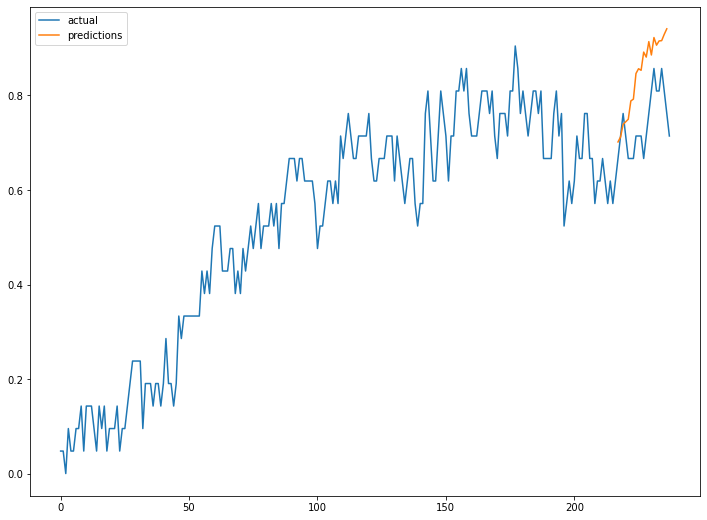

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.259684241547857 actual 0.8006535947712417 prediction 0.702496
num 1 11.581990411204677 actual 0.8104575163398693 prediction 0.7165904
num 2 8.44623669084296 actual 0.8137254901960784 prediction 0.7449963
num 3 9.528756475448606 actual 0.8169934640522876 prediction 0.73914415
num 4 9.653299808502195 actual 0.8169934640522876 prediction 0.73812664
num 5 2.859008882150229 actual 0.8202614379084967 prediction 0.7968101
num 6 3.325487785188571 actual 0.826797385620915 prediction 0.79930234
num 7 3.841986879706393 actual 0.8366013071895424 prediction 0.8687434
num 8 4.223957715347481 actual 0.8464052287581698 prediction 0.882157
num 9 3.3499187436597273 actual 0.8529411764705881 prediction 0.881514
num 10 8.857989719158818 actual 0.8594771241830064 prediction 0.9356095
num 11 4.930340024558003 actual 0.8627450980392155 prediction 0.90528136
num 12 8.882655512611844 actual 0.8660130718954246 prediction 0.942938
num 13 3.8059099665228158 actual 0.8660130718954246 prediction 0.89897275

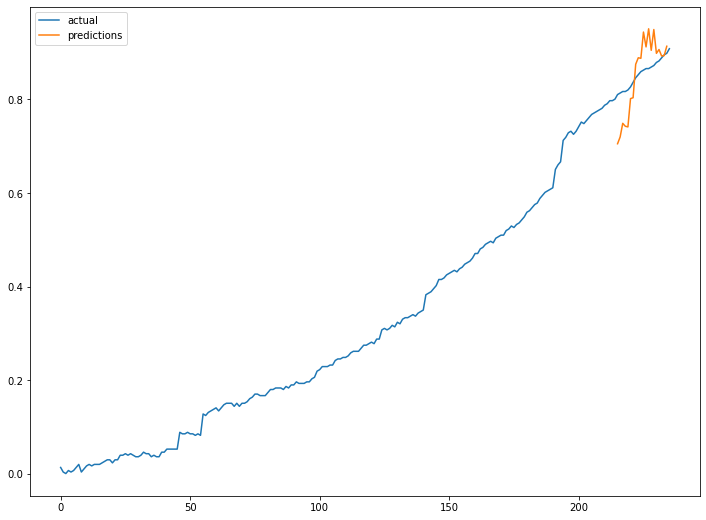

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.455969130210426 actual 0.6762402088772845 prediction 0.63934475
num 1 6.0593080791559935 actual 0.6892950391644908 prediction 0.6475285
num 2 4.573419232493458 actual 0.6971279373368144 prediction 0.66524535
num 3 4.508122148123794 actual 0.702349869451697 prediction 0.6706871
num 4 4.658015275793304 actual 0.7075718015665795 prediction 0.674613
num 5 1.9604431669207414 actual 0.7154046997389034 prediction 0.7013796
num 6 2.0759187291599908 actual 0.7284595300261096 prediction 0.7133373
num 7 1.1183918575515979 actual 0.7389033942558747 prediction 0.7471672
num 8 0.8597559837514291 actual 0.7493472584856395 prediction 0.7557898
num 9 0.9151471939879048 actual 0.7545691906005221 prediction 0.7614746
num 10 2.3712951575529946 actual 0.7650130548302871 prediction 0.7831538
num 11 1.5164698467773565 actual 0.7676240208877285 prediction 0.7792648
num 12 4.5112222230353245 actual 0.7676240208877285 prediction 0.80225325
num 13 1.8778500140913523 actual 0.7780678851174934 prediction 0

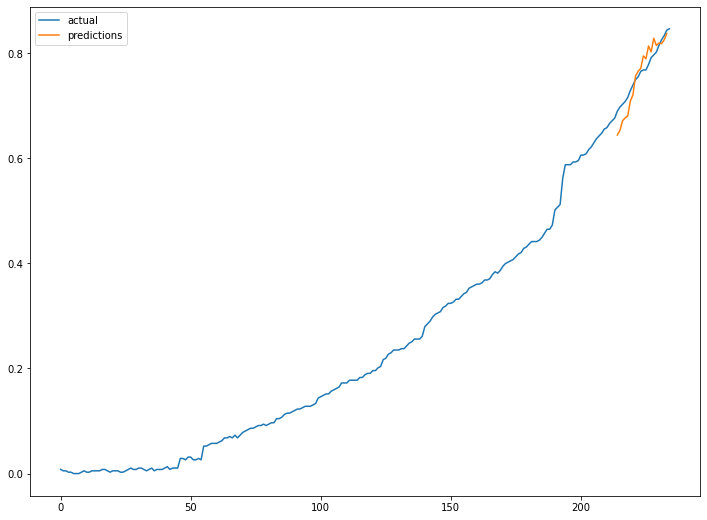

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.71992864106824 actual 0.7916666666666661 prediction 0.7226339
num 1 7.147231854890452 actual 0.7916666666666661 prediction 0.7350844
num 2 2.4192860251978097 actual 0.7916666666666661 prediction 0.772514
num 3 2.016758918762207 actual 0.75 prediction 0.7651257
num 4 3.126003867701408 actual 0.7916666666666661 prediction 0.76691914
num 5 10.669898986816406 actual 0.75 prediction 0.83002424
num 6 0.7803392410279025 actual 0.8333333333333339 prediction 0.8268305
num 7 8.514809608459394 actual 0.8333333333333339 prediction 0.9042901
num 8 0.41156682101169484 actual 0.9166666666666661 prediction 0.92043936
num 9 4.0029401364534385 actual 0.9583333333333339 prediction 0.9199718
num 10 1.9266418788743425 actual 0.9583333333333339 prediction 0.976797
num 11 0.48144381979243583 actual 0.9583333333333339 prediction 0.9537195
num 12 4.0717995685079185 actual 0.9583333333333339 prediction 0.99735475
num 13 1.0123066280199746 actual 0.9583333333333339 prediction 0.94863206
num 14 8.74761234

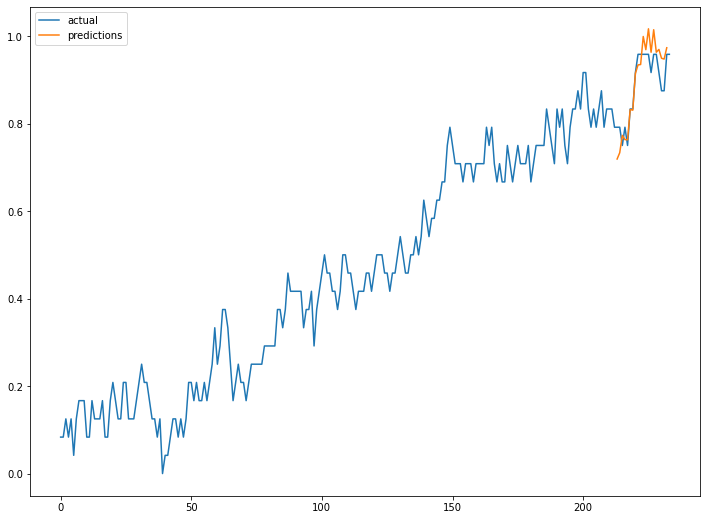

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.926965010793573 actual 0.8482142857142856 prediction 0.7385659
num 1 11.52720848719275 actual 0.8571428571428568 prediction 0.7583382
num 2 6.55688737568101 actual 0.8482142857142856 prediction 0.79259783
num 3 8.807928275063373 actual 0.8526785714285712 prediction 0.77757525
num 4 10.815949784111712 actual 0.8660714285714284 prediction 0.7723976
num 5 2.331270490373884 actual 0.875 prediction 0.8546014
num 6 3.7702860565959964 actual 0.8794642857142856 prediction 0.84630597
num 7 5.8324468794780016 actual 0.8883928571428568 prediction 0.9402079
num 8 8.315273246379846 actual 0.8839285714285712 prediction 0.95742965
num 9 6.920582565230986 actual 0.8883928571428568 prediction 0.9498748
num 10 16.10424735329371 actual 0.8839285714285712 prediction 1.0262786
num 11 9.556466102600107 actual 0.8928571428571428 prediction 0.97818273
num 12 13.728825408633433 actual 0.901785714285714 prediction 1.0255903
num 13 5.31988472774111 actual 0.90625 prediction 0.95446146
num 14 11.80648803

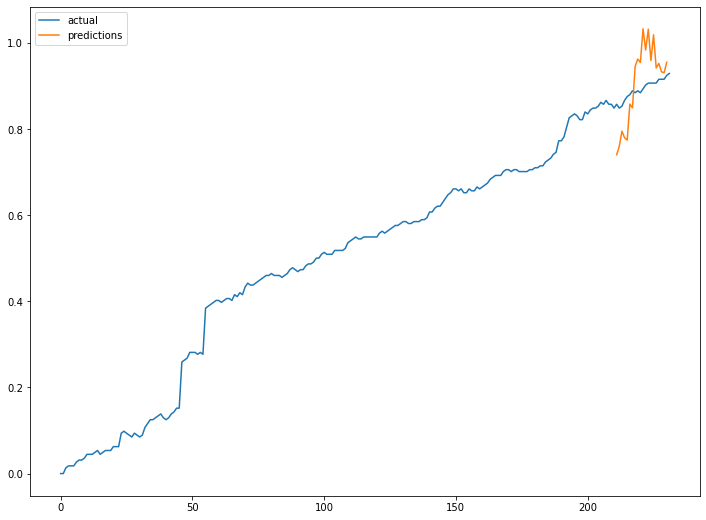

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.874088567846107 actual 0.8500000000000014 prediction 0.74057025
num 1 4.729276895523156 actual 0.8000000000000007 prediction 0.7621658
num 2 5.387028058369955 actual 0.75 prediction 0.7904027
num 3 2.8403600056966143 actual 0.75 prediction 0.7713027
num 4 2.041959762573242 actual 0.75 prediction 0.7653147
num 5 13.193416595458984 actual 0.75 prediction 0.8489506
num 6 19.73328249795078 actual 0.7000000000000011 prediction 0.838133
num 7 32.7423197882514 actual 0.7000000000000011 prediction 0.92919624
num 8 45.15662193298332 actual 0.6500000000000004 prediction 0.94351804
num 9 33.651077747344765 actual 0.7000000000000011 prediction 0.93555754
num 10 34.38976605733235 actual 0.75 prediction 1.0079232
num 11 27.61859893798828 actual 0.75 prediction 0.9571395
num 12 42.92211191994782 actual 0.7000000000000011 prediction 1.0004548
num 13 32.49262741633804 actual 0.7000000000000011 prediction 0.9274484
num 14 23.223416507244004 actual 0.8000000000000007 prediction 0.98578733
num 15

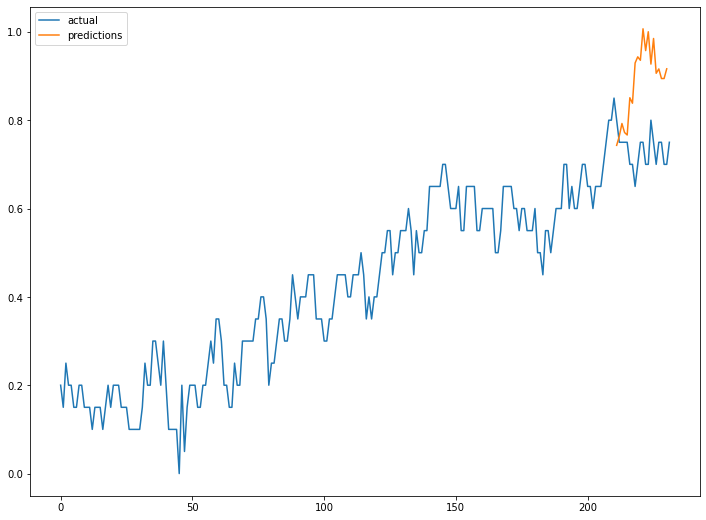

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 13.189190998673341 actual 0.8421052631578938 prediction 0.7310384
num 1 13.724162361838582 actual 0.8684210526315788 prediction 0.74923754
num 2 7.568241283297436 actual 0.8421052631578938 prediction 0.7783727
num 3 11.607775182434988 actual 0.8684210526315788 prediction 0.7676167
num 4 11.869091698617627 actual 0.8684210526315788 prediction 0.76534736
num 5 0.8889812976120802 actual 0.8421052631578938 prediction 0.8346191
num 6 1.646585233749981 actual 0.8157894736842097 prediction 0.82922214
num 7 11.639456979690168 actual 0.8157894736842097 prediction 0.91074294
num 8 9.800964593887452 actual 0.8421052631578938 prediction 0.9246397
num 9 8.857616037130477 actual 0.8421052631578938 prediction 0.9166957
num 10 13.042389624046583 actual 0.8684210526315788 prediction 0.9816839
num 11 11.74959465861333 actual 0.8421052631578938 prediction 0.9410492
num 12 9.783824051127754 actual 0.8947368421052628 prediction 0.9822763
num 13 6.229505033204073 actual 0.8684210526315788 prediction 0

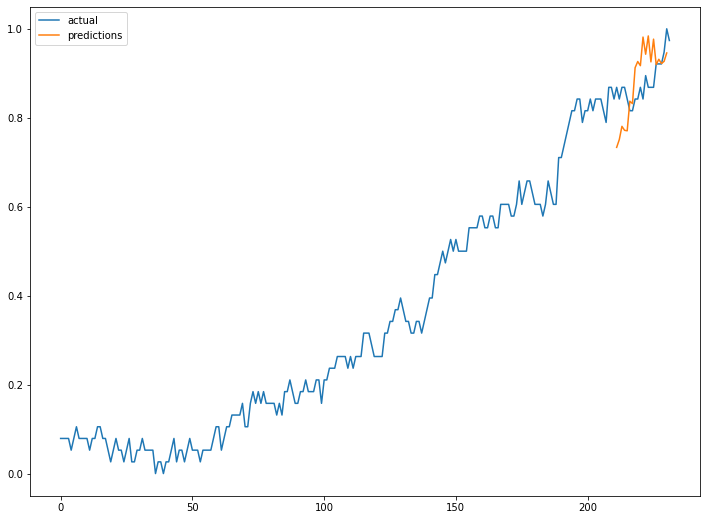

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.54519724845896 actual 0.76923076923077 prediction 0.7034985
num 1 1.830311825401033 actual 0.7307692307692317 prediction 0.7173939
num 2 1.8020623608638031 actual 0.7307692307692317 prediction 0.74393815
num 3 1.2421564051978142 actual 0.7307692307692317 prediction 0.7398465
num 4 6.934426228205469 actual 0.6923076923076916 prediction 0.74031526
num 5 3.1721407175062986 actual 0.76923076923077 prediction 0.79363185
num 6 1.4062336512975164 actual 0.8076923076923084 prediction 0.79633427
num 7 6.711484137035462 actual 0.8076923076923084 prediction 0.86190045
num 8 3.3093804662877195 actual 0.8461538461538467 prediction 0.8741563
num 9 7.8764166150773365 actual 0.8076923076923084 prediction 0.8713095
num 10 19.869971275329462 actual 0.76923076923077 prediction 0.9220767
num 11 16.186029314994688 actual 0.76923076923077 prediction 0.8937387
num 12 20.802701711654535 actual 0.76923076923077 prediction 0.92925155
num 13 9.99737183252961 actual 0.8076923076923084 prediction 0.8884403

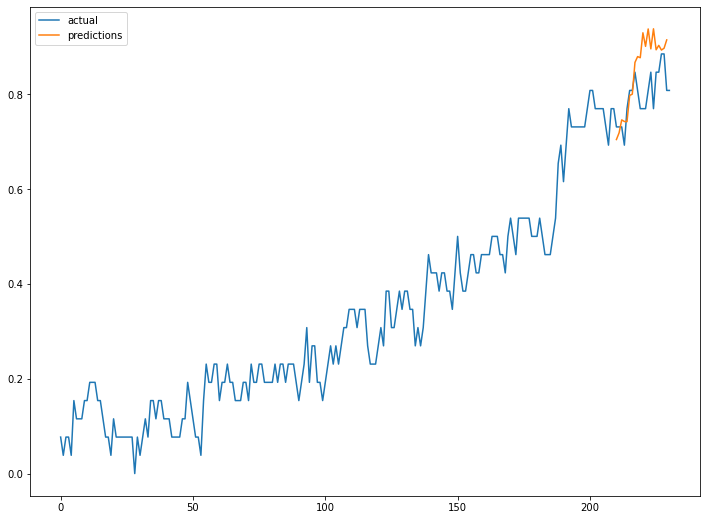

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.109954595565766 actual 0.7389162561576352 prediction 0.6789905
num 1 7.885692229396415 actual 0.7487684729064039 prediction 0.6897229
num 2 5.38432064399216 actual 0.7536945812807878 prediction 0.71311325
num 3 6.120860576629607 actual 0.7586206896551722 prediction 0.7121866
num 4 7.152747038083193 actual 0.7684729064039408 prediction 0.713506
num 5 2.007581056303286 actual 0.7733990147783252 prediction 0.7578724
num 6 1.7071719411052875 actual 0.7783251231527091 prediction 0.7650378
num 7 4.569904759245123 actual 0.7832512315270934 prediction 0.81904507
num 8 5.222646221518526 actual 0.7881773399014778 prediction 0.82934105
num 9 4.78907175686048 actual 0.7931034482758621 prediction 0.83108574
num 10 9.164985756815259 actual 0.798029556650246 prediction 0.87116885
num 11 6.66820381158668 actual 0.798029556650246 prediction 0.8512438
num 12 9.123988086130574 actual 0.8078817733990147 prediction 0.8815928
num 13 3.676494795405251 actual 0.8226600985221673 prediction 0.85290515
n

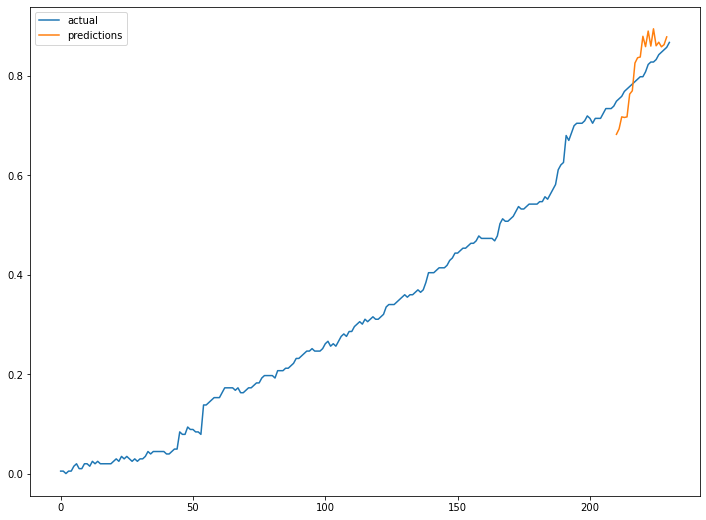

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()